##*Bank Customer Satisfaction Prediction Using CNN and Feature Selection*

By Nakshatra Singh

This notebook will show you how to build a Neural Network to predict if a particular bank customer is satisfied or not.

##Using Google GPU for Training

Google colab offers free GPUs and TPUs! Since we'll be training a large model it's best to take advantage of this (in this case we'll use GPU), otherwise training can take long time.

A GPU can be added by going to the menu and selecting:

`Edit -> Notebook Settings -> Hardware Accelerator -> (GPU)`

Then run the following cell to confirm that a GPU is detected. 

In [1]:
import tensorflow as tf
# Get the device GPU name 
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
  print('Found GPU at : {}'.format(device_name)) 
else:
  raise SystemError('GPU not found!') 

Found GPU at : /device:GPU:0


###**1. Imports**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam 
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0


###**2. Retrieve and Inspect Dataset**

Let's download the dataset which is uploaded on my google drive.

In [3]:
!gdown --id 1f0mazxiFNiz-UAYmubq_UHOe8On3mPzT

Downloading...
From: https://drive.google.com/uc?id=1f0mazxiFNiz-UAYmubq_UHOe8On3mPzT
To: /content/santander-train.csv
59.4MB [00:00, 105MB/s] 


We'll use `pandas` to parse the csv files. 

In [4]:
df = pd.read_csv('/content/santander-train.csv')

Let's take a look at the first few rows of the table just to see what's in there. 

In [5]:
df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [6]:
df.shape

(76020, 371)

Now we are going to create a feature space X. Feature space will only contain the column which provide information necessary for prediction. ID and TARGET do not play any role in prediction, so we are going to remove them using drop(). After droppring the 2 columns you can see that the number of columns have reduced to 369. 

In [7]:
x = df.drop(labels=['ID', 'TARGET'], axis = 1)
x.shape

(76020, 369)

Lets create a variable y which contains the values which have to be predicted i.e. TARGET. 

In [8]:
y = df['TARGET']

Now we will split the data into training and validation set with the help of train_test_split(). test_size = 0.2 will keep 20% data for validation and 80% data will be used for training the model. random_state controls the shuffling applied to the data before applying the split. stratify = y means that the data is split in a stratified fashion, using y as the class labels. 

In [9]:
xtrain, xvalid, ytrain, yvalid = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y) 

As we can see, the training dataset consists of 60816 rows i.e. 80% of the data and the testing dataset consists of 15204 rows i.e 20% of the data. 

In [10]:
xtrain.shape, xvalid.shape 

((60816, 369), (15204, 369))

###**3. Feature Selection**

Feature selection is the process of reducing the number of input variables when developing a predictive model.

- Constant Features are the features that show single values in all the observations in the dataset. These features provide no information that allows ML models to predict the target.
- Quasi constant features, as the name suggests, are the features that are almost constant. In other words, these features have the same values for a very large subset of the outputs. They have less variance. Such features are not very useful for making predictions.
- Duplicate Features as the name suggests are duplicated in the dataset.


Here we have set the variance threshold to 1% i.e. if any column has variance less than 1% it will be removed. In other words only the columns having variance greater than 99% will be retained. We are fitting VarianceThreshold() to the training data and not the test data. We are only transforming the test data. 

In [11]:
filter = VarianceThreshold(0.01)
xtrain = filter.fit_transform(xtrain)
xvalid = filter.transform(xvalid)

xtrain.shape, xvalid.shape

((60816, 273), (15204, 273))

After removing the Quasi constant features we can see that 96 features are removed from the dataset. 

Now we will remove the duplicate features. We don’t have any direct function to remove duplicate features but we have functions to check for duplicate rows. Hence we are taking transpose of the data set using .T. As we can see after taking transpose the shape of xtrain_T is exactly opposite to that of xtrain. 

In [12]:
xtrain_T = xtrain.T
xvalid_T = xvalid.T

xtrain_T = pd.DataFrame(xtrain_T)
xvalid_T = pd.DataFrame(xvalid_T)

xtrain_T.shape

(273, 60816)

.duplicated() returns a boolean Series denoting duplicate rows. We can see that 17 features are duplicated. 

In [13]:
xtrain_T.duplicated().sum()

17

Now we will see the list of dupicated features. The features having index True are duplicated. 

In [14]:
duplicated_features = xtrain_T.duplicated()
duplicated_features[70:90]

70    False
71    False
72     True
73    False
74     True
75    False
76    False
77    False
78    False
79    False
80    False
81    False
82    False
83    False
84    False
85    False
86    False
87    False
88    False
89    False
dtype: bool

We have to retain the features with False value because they are not duplicated. So here we are going to use inversion i.e. we are going to change the False value to True and viceversa. 

In [15]:
features_to_keep = [not index for index in duplicated_features]
features_to_keep[70:90] 

[True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

Now as we have inverted the values, we have to retain the features with value True. We also have to take transpose once again to get the data back in original shape. Here we have done it for xtrain. 

In [16]:
xtrain = xtrain_T[features_to_keep].T
xtrain.shape

(60816, 256)

In [17]:
xvalid = xvalid_T[features_to_keep].T
xvalid.shape

(15204, 256)

After removing the Quasi constant features we can see that 96 features are removed from the dataset. 

In [18]:
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xvalid = scaler.transform(xvalid)
xtrain

array([[ 3.80478472e-02, -5.56029626e-01, -5.27331414e-02, ...,
        -1.87046327e-02, -1.97720391e-02,  3.12133758e-03],
       [ 3.80478472e-02, -7.87181903e-01, -5.27331414e-02, ...,
        -1.87046327e-02, -1.97720391e-02, -1.83006062e-01],
       [ 3.80478472e-02, -7.87181903e-01, -5.27331414e-02, ...,
        -1.87046327e-02, -1.97720391e-02,  1.17499225e+00],
       ...,
       [ 3.80478472e-02,  5.99731758e-01, -5.27331414e-02, ...,
        -1.87046327e-02, -1.97720391e-02, -2.41865113e-01],
       [ 3.80478472e-02, -1.70775831e-01, -5.27331414e-02, ...,
        -1.87046327e-02, -1.97720391e-02,  3.12133758e-03],
       [ 3.80478472e-02,  2.91528722e-01,  7.65192053e+00, ...,
        -1.87046327e-02, -1.97720391e-02,  3.12133758e-03]])

In [19]:
xtrain.shape, xvalid.shape

((60816, 256), (15204, 256))

Our data is 2 dimensional but neural networks accept 3 dimensional data. So we have to reshape() the data.

In [20]:
xtrain = xtrain.reshape(60816, 256,1)
xvalid = xvalid.reshape(15204, 256, 1)
xtrain.shape, xvalid.shape

((60816, 256, 1), (15204, 256, 1))

Finally we'll convert our y variables to numpy arrays.

In [21]:
ytrain = ytrain.to_numpy()
yvalid = yvalid.to_numpy()

###**4. Bulding the Neural Network**

Model Architecture.

In [22]:
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape = (256,1)))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.3))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

Let's see how the model looks.

In [23]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 254, 32)           128       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 127, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 125, 64)           6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 64)            0

Now we will compile and fit the model. We are using Adam optimizer with 0.00005 learning rate. We will use 10 epochs to train the model. An epoch is an iteration over the entire data provided. validation_data is the data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. As metrics = `['accuracy']` the model will be evaluated based on the accuracy. 

In [24]:
model.compile(optimizer=Adam(lr=0.00005), loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(xtrain, ytrain, epochs=10, validation_data=(xvalid, yvalid), verbose=1)

Epoch 1/10
1901/1901 [==============================] - 19s 10ms/step - loss: 0.2284 - accuracy: 0.9506 - val_loss: 0.1909 - val_accuracy: 0.9604
Epoch 2/10
1901/1901 [==============================] - 18s 9ms/step - loss: 0.1776 - accuracy: 0.9592 - val_loss: 0.1794 - val_accuracy: 0.9603
Epoch 3/10
1901/1901 [==============================] - 18s 9ms/step - loss: 0.1668 - accuracy: 0.9602 - val_loss: 0.1733 - val_accuracy: 0.9603
Epoch 4/10
1901/1901 [==============================] - 18s 9ms/step - loss: 0.1631 - accuracy: 0.9603 - val_loss: 0.1762 - val_accuracy: 0.9603
Epoch 5/10
1901/1901 [==============================] - 18s 10ms/step - loss: 0.1626 - accuracy: 0.9604 - val_loss: 0.1775 - val_accuracy: 0.9602
Epoch 6/10
1901/1901 [==============================] - 18s 10ms/step - loss: 0.1589 - accuracy: 0.9604 - val_loss: 0.1629 - val_accuracy: 0.9605
Epoch 7/10
1901/1901 [==============================] - 18s 10ms/step - loss: 0.1577 - accuracy: 0.9604 - val_loss: 0.1686 - va

history gives us the summary of all the accuracies and losses calculated after each epoch. 

In [25]:
history.history 

{'accuracy': [0.9506050944328308,
  0.9591719508171082,
  0.9601749777793884,
  0.9603065252304077,
  0.9604380130767822,
  0.960405170917511,
  0.9604380130767822,
  0.960388720035553,
  0.960388720035553,
  0.9604544639587402],
 'loss': [0.2284086048603058,
  0.17755845189094543,
  0.16681690514087677,
  0.1631041318178177,
  0.16260381042957306,
  0.15890401601791382,
  0.15772928297519684,
  0.15520358085632324,
  0.15483903884887695,
  0.1538625806570053],
 'val_accuracy': [0.960405170917511,
  0.9602736234664917,
  0.960339367389679,
  0.9602736234664917,
  0.9602078199386597,
  0.9604709148406982,
  0.9604709148406982,
  0.9604709148406982,
  0.9604709148406982,
  0.960339367389679],
 'val_loss': [0.19087235629558563,
  0.1793910264968872,
  0.17329806089401245,
  0.17624983191490173,
  0.17754679918289185,
  0.16287384927272797,
  0.16858336329460144,
  0.17016957700252533,
  0.16176503896713257,
  0.16021005809307098]}

We will now plot the model accuracy and model loss. In model accuracy we will plot the training accuracy and validation accuracy and in model loss we will plot the training loss and validation loss. 

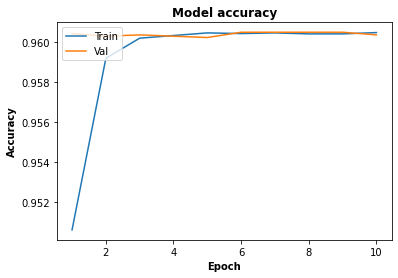

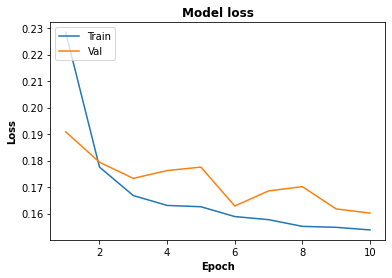

In [27]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy', fontweight='bold')
  plt.ylabel('Accuracy', fontweight='bold')
  plt.xlabel('Epoch', fontweight='bold')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss', fontweight='bold')
  plt.ylabel('Loss', fontweight='bold')
  plt.xlabel('Epoch', fontweight='bold')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, 10) 